In [4]:
# basic i/o
import os

# data structures
import numpy as np
import pandas as pd

# cleaning data
from scipy import sparse
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# regressors
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import GradientBoostingRegressor

# getting rid of annoying warnings.
import warnings
warnings.filterwarnings('ignore')

# plots
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Bench Mark Set Up

In [5]:
FILE_NAME = 'energy.csv'

def load_data(file_name=FILE_NAME, ratio=0.9):
    data = pd.read_csv(file_name).sample(frac=1)
    
    slice_ind = int(data.shape[0]*ratio)
    
    return data.iloc[0:slice_ind], data.iloc[slice_ind:]

# 2 Preprocessing Data
# 2.1 Remove inrelavant featrues

In [6]:
def seperate_data():
    
    _data = load_data(ratio=1)[0]
    COST_COLS = _data.iloc[:,644:671].columns
    VAR_COLS = _data.iloc[:, 0:644].columns.difference(COST_COLS)

    # Drop:
    # 'Z...' = imputation indicators
    # 'BRRWT' = duplicated columns
    # 'KWH' , 'BTU' = electricity usage, which is not an independent variable
    to_drop = []
    for col in VAR_COLS:
        if col[0] == 'Z' or \
            'BRRWT' in col or \
            'KWH' in col or \
            col == 'DOEID' or \
            'BTU' in col:
            to_drop.append(col)

    VAR_COLS = VAR_COLS.difference(pd.Index(to_drop))
    
    return VAR_COLS, COST_COLS

In [7]:
VAR_COLS, COST_COLS = seperate_data()

In [8]:
VAR_COLS.size

282

# 2.2 Preprocessor class

In [9]:
class Preprocessor(object):
    def __init__(self, 
                 cost_cols=COST_COLS,
                 var_cols=VAR_COLS,
                 imputer=SimpleImputer(), 
                 normalizer=MinMaxScaler()):
        
        self.var_cols = VAR_COLS
        self.cost_cols = COST_COLS
        
        self.imputer = imputer
        self.normalizer = normalizer
        self.num_inds = [] # does not include self.cost_cols
        self.cat_inds = []
        
    # separate_num_and_cat: self, pd.DataFrame --> void
    # X = data[self.var_cols]
    def seperate_num_and_cat(self, X):
        # numerical data type
        cont_type = [int, np.int64, float, np.float64]

        for col in X.columns:
            if X[col].dtype in cont_type:
                self.num_inds.append(col)
                #data[col].to_numeric()
            else:
                self.cat_inds.append(col)
        
        self.num_inds = pd.Index(self.num_inds)
        self.cat_inds = pd.Index(self.cat_inds)
                
    # indata is not consumed, a copy is made
    def fit(self, indata):
        data = indata.copy()
        X = data[self.var_cols]
        
        self.seperate_num_and_cat(X)
        
        X[self.num_inds] = self.imputer.fit_transform(X[self.num_inds])
        X[self.num_inds] = self.normalizer.fit(X[self.num_inds])
    
    # transform: self, pd.DataFrame --> pd.DataFrame
    # X is consumed and modified
    # take log of SalePrice
    def transform(self, X):
        
        X[self.num_inds] = self.imputer.transform(X[self.num_inds])
        X[self.num_inds] = self.normalizer.transform(X[self.num_inds])
        
        return X
    
    # fit_transform: self, pd.DataFrame --> pd.DataFrame
    # data includes all columns
    # data is consumed and modified
    # take log of SalePrice
    def fit_transform(self, data):
        self.fit(data)
        return self.transform(data)


# 3. Correlations
# 3.1 Ranking independent variables by their Pearson correlation with dependent ones (i.e. cost of certain electrical usage)

In [8]:
_data, _ = load_data(ratio=1)
preproc = Preprocessor()
preX = preproc.fit_transform(_data)

In [9]:
X = preX[preproc.num_inds.append(COST_COLS)]

In [10]:
def heatMap(cost_col, num_inds, X, k=10):
    ind = pd.Index.append(num_inds, cost_col)
    Y = X[ind]
    corrmat = np.abs(Y.corr())
    cols = corrmat.nlargest(k, cost_col)[cost_col].index
    
    corrmat_small = np.abs(X[cols].corr())

    f, ax = plt.subplots(figsize=(12,10))
    sns.heatmap(corrmat_small, vmax = 0.8, square=True);

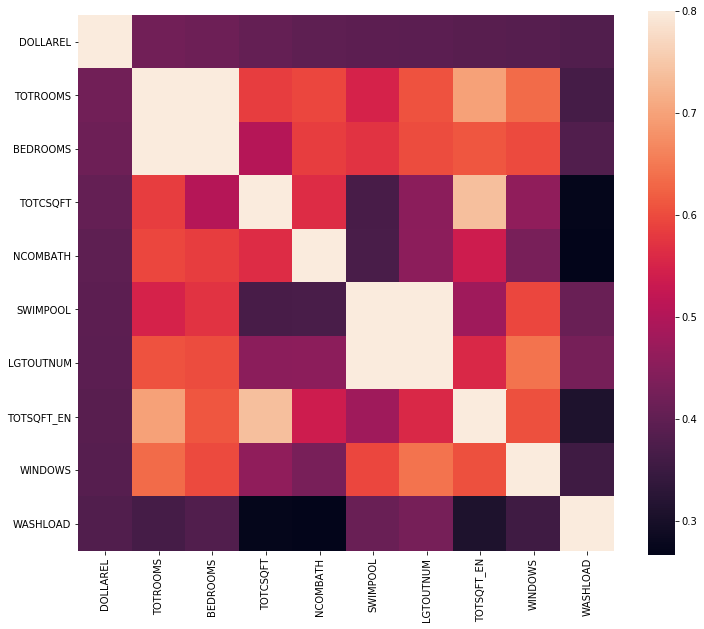

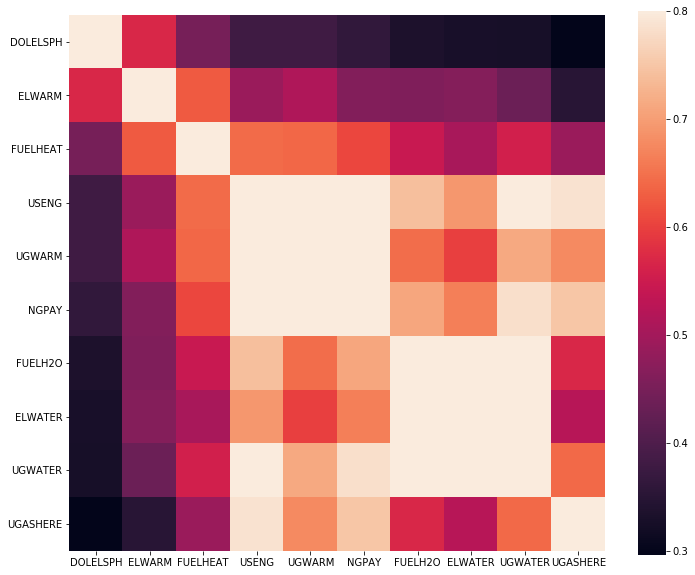

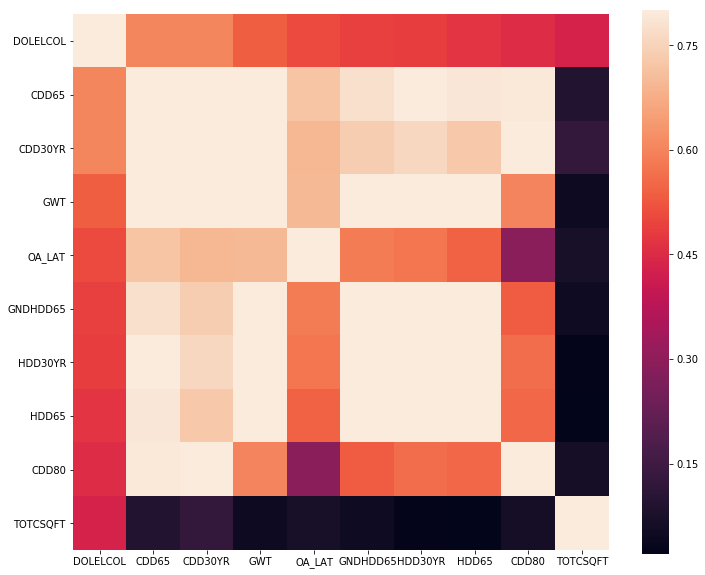

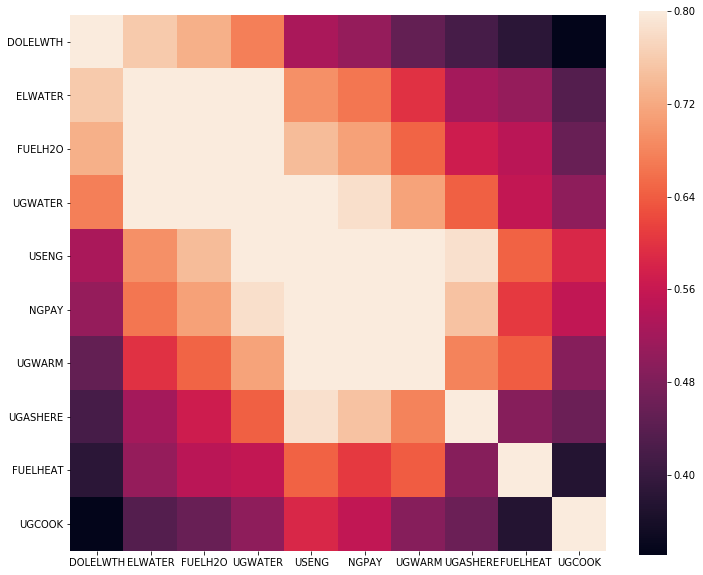

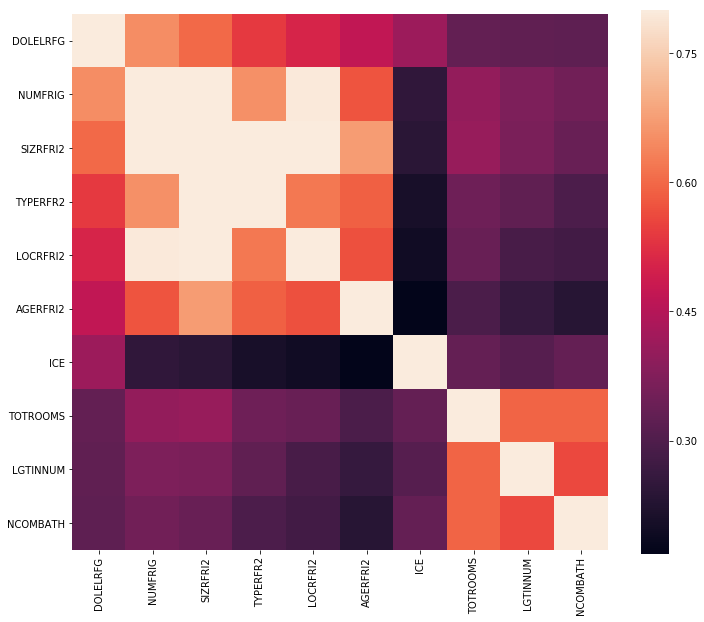

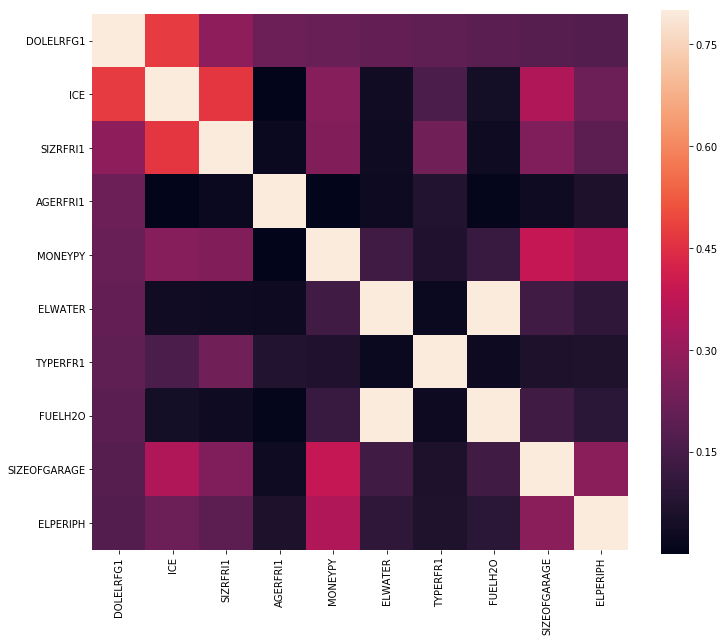

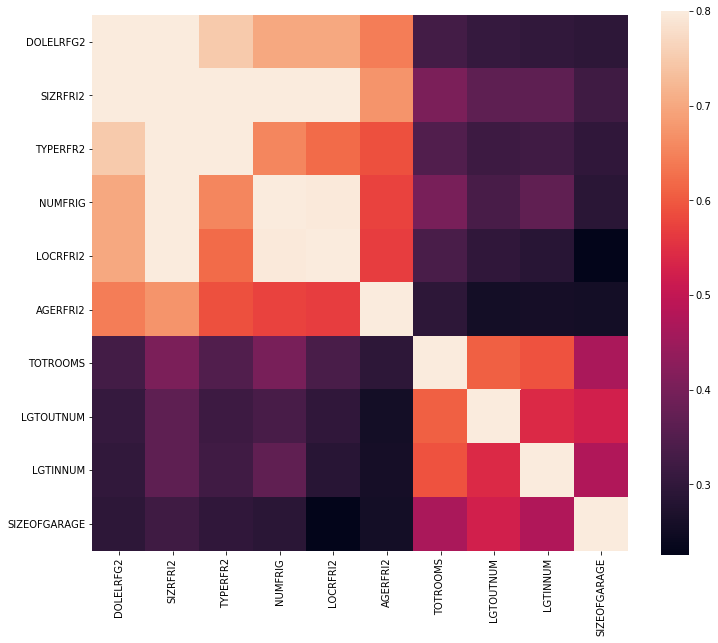

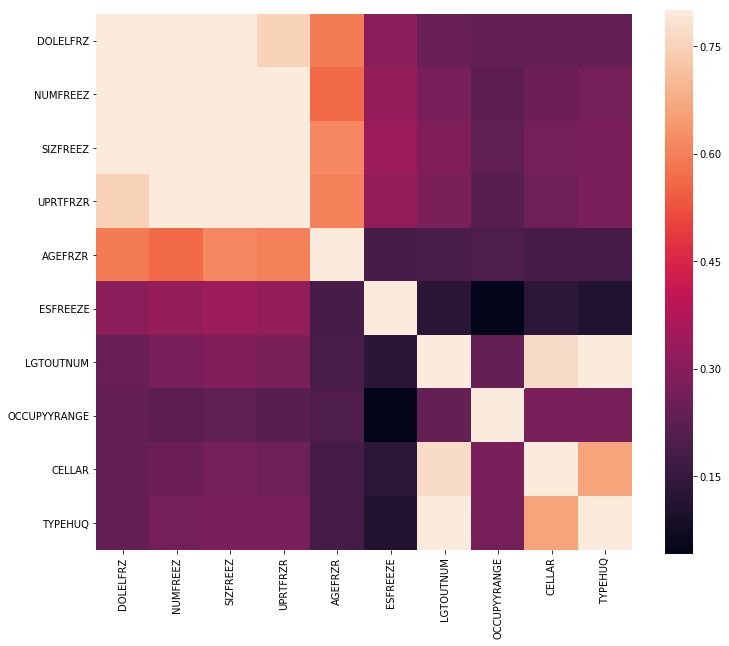

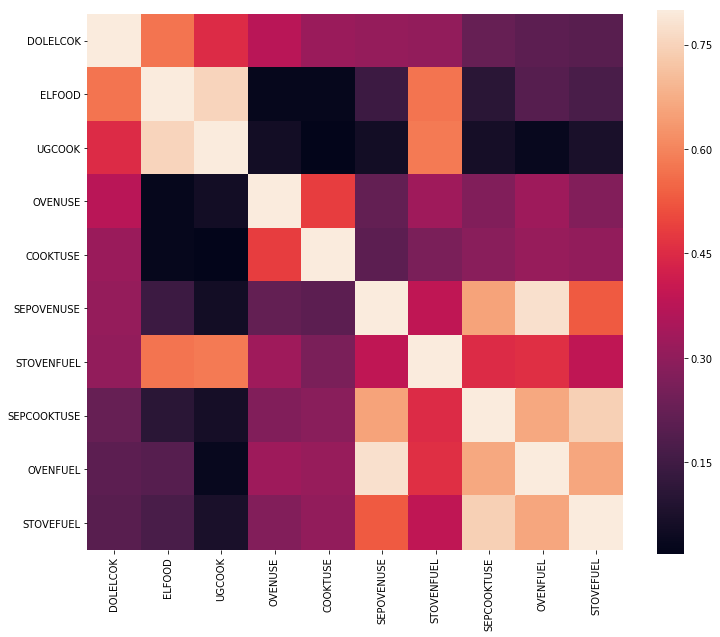

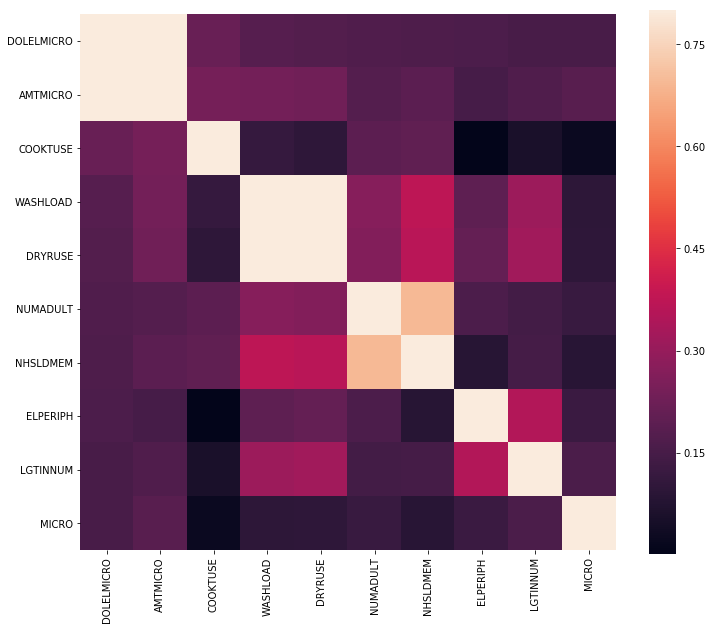

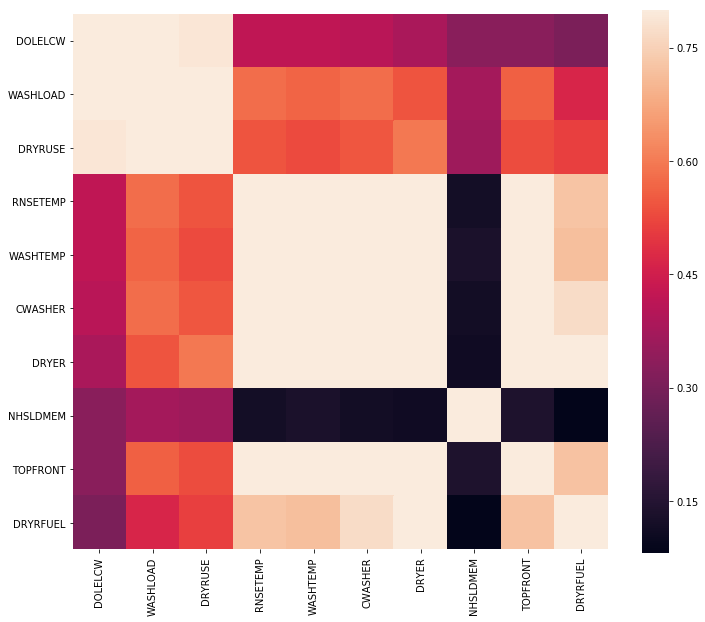

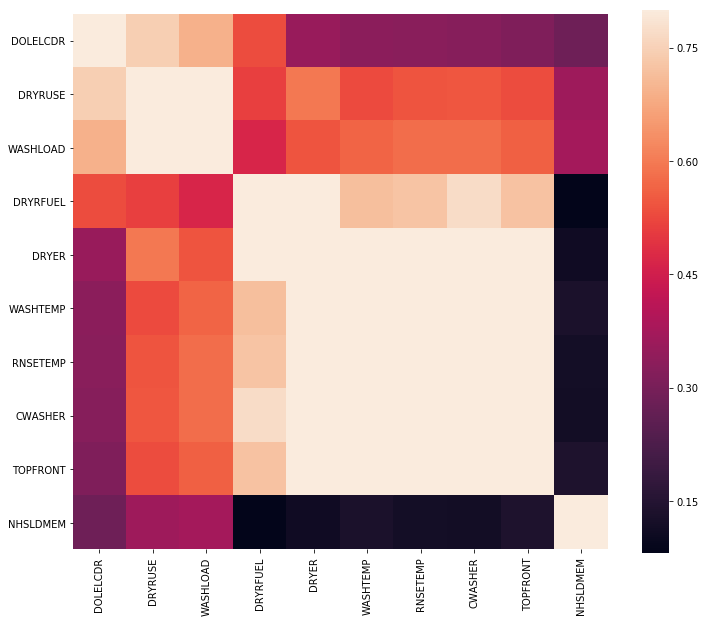

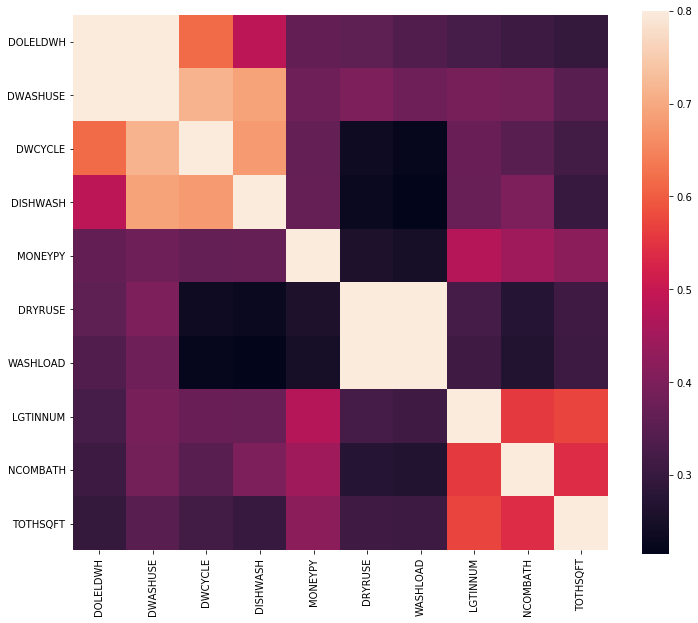

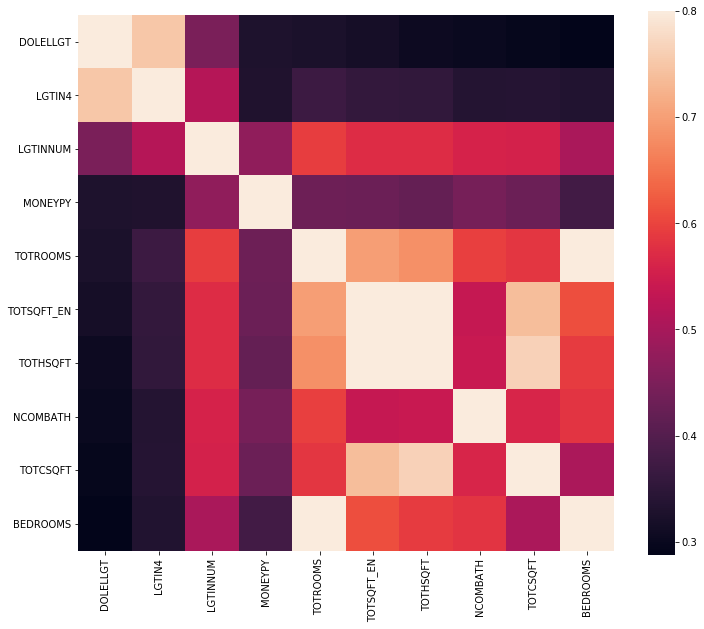

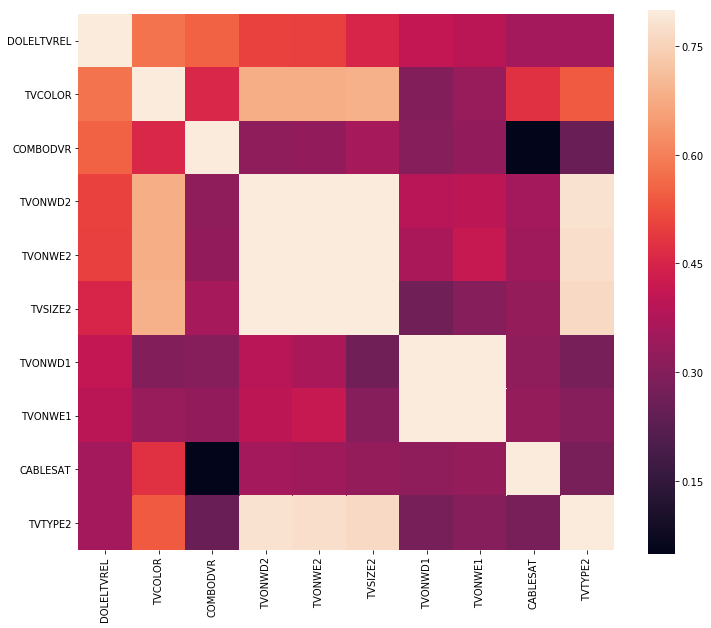

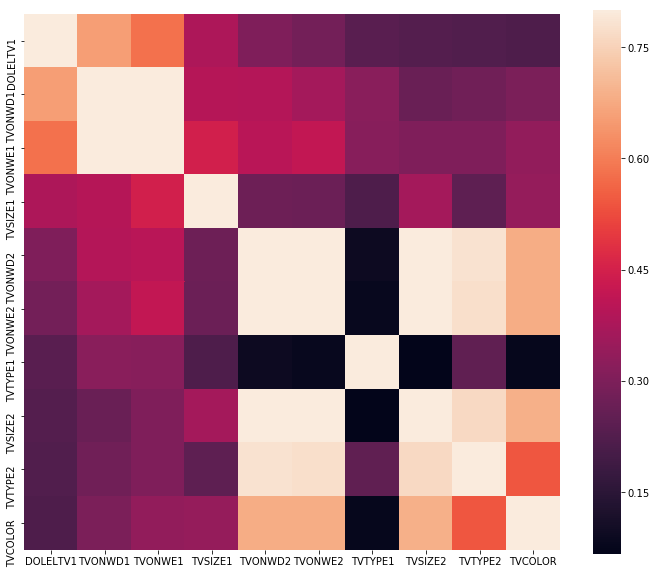

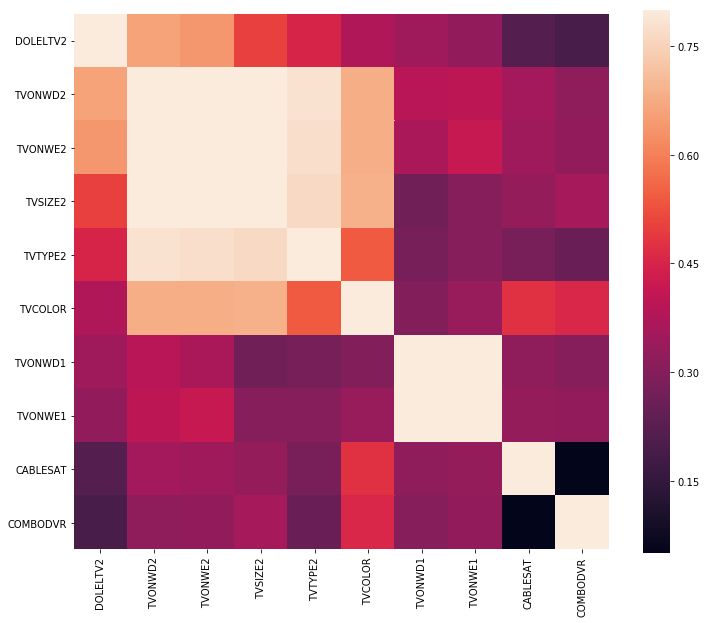

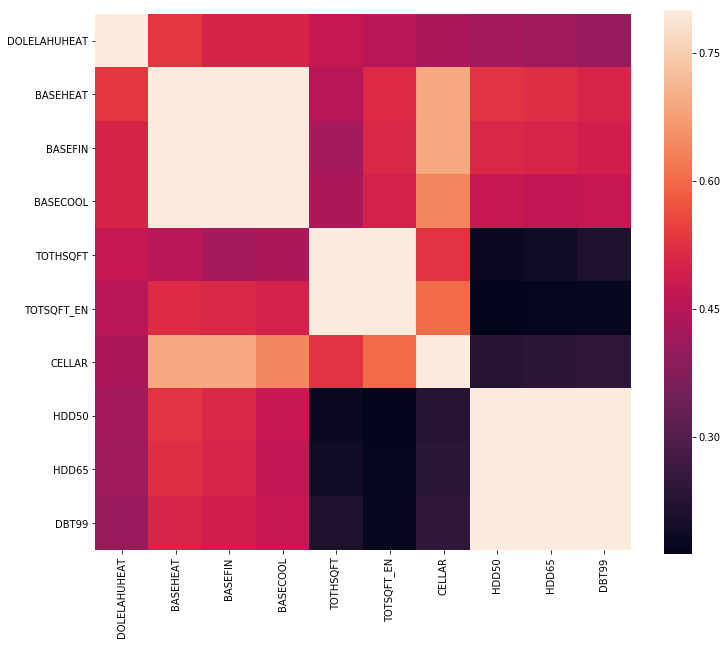

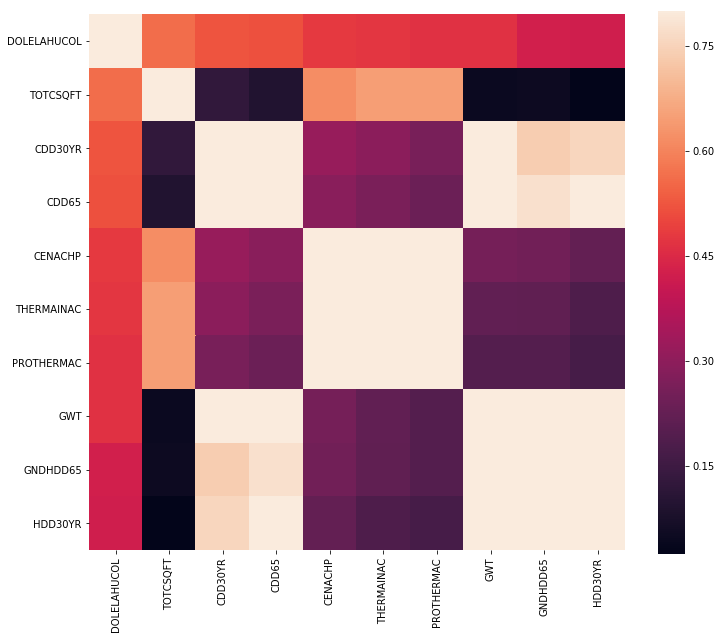

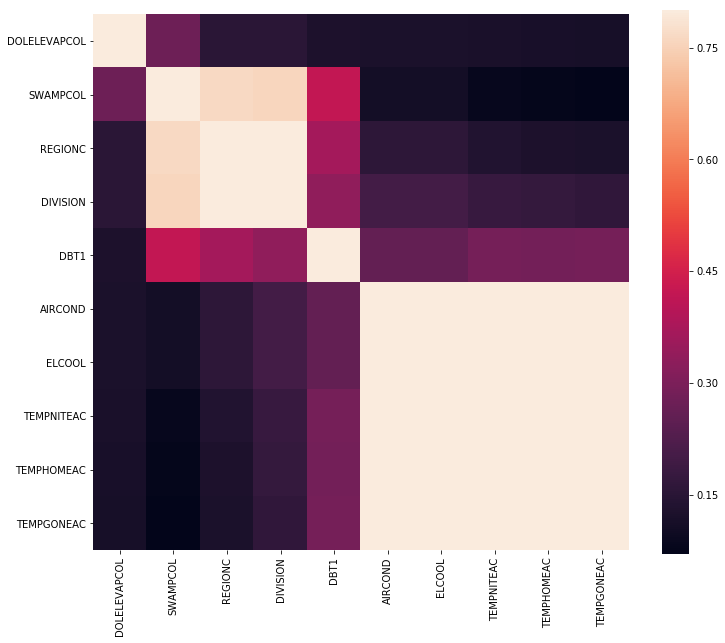

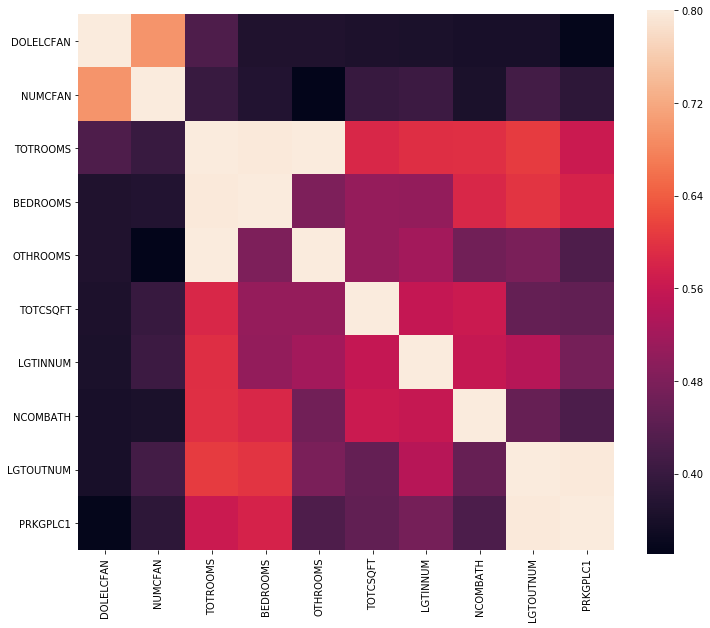

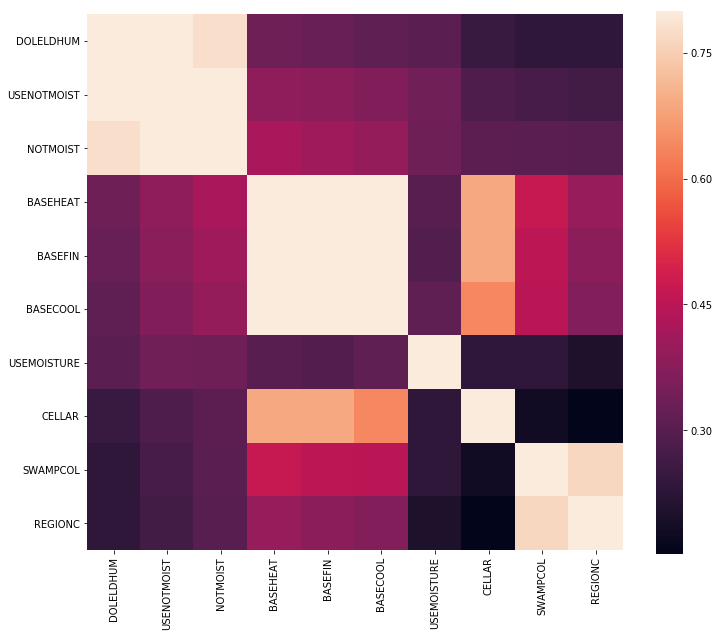

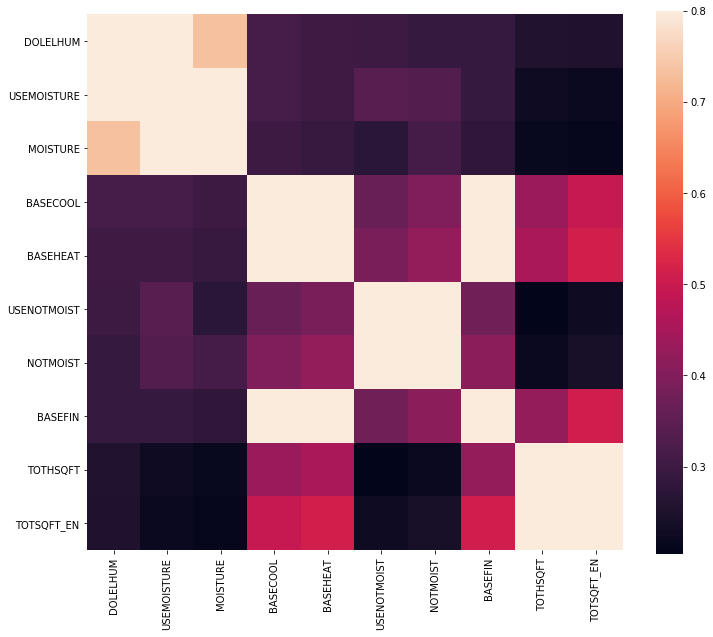

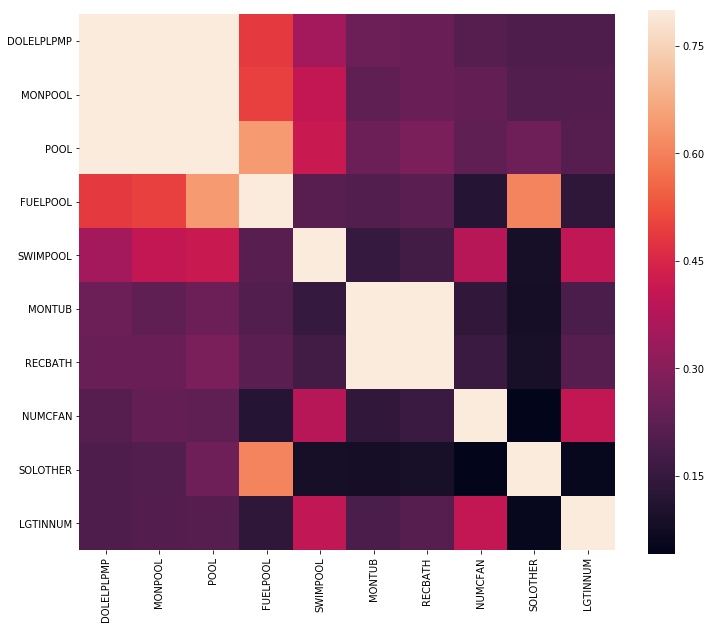

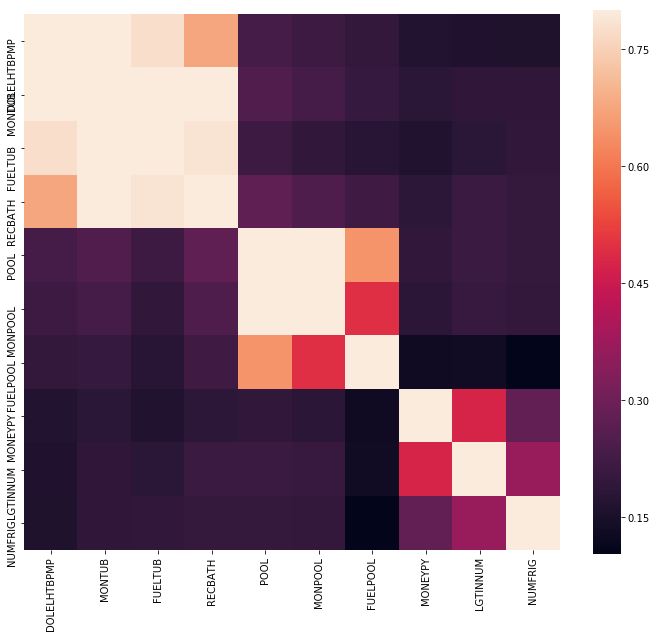

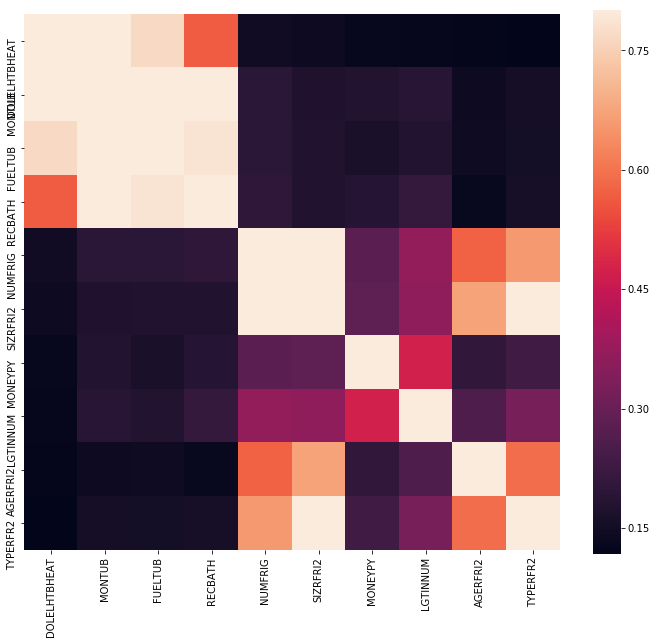

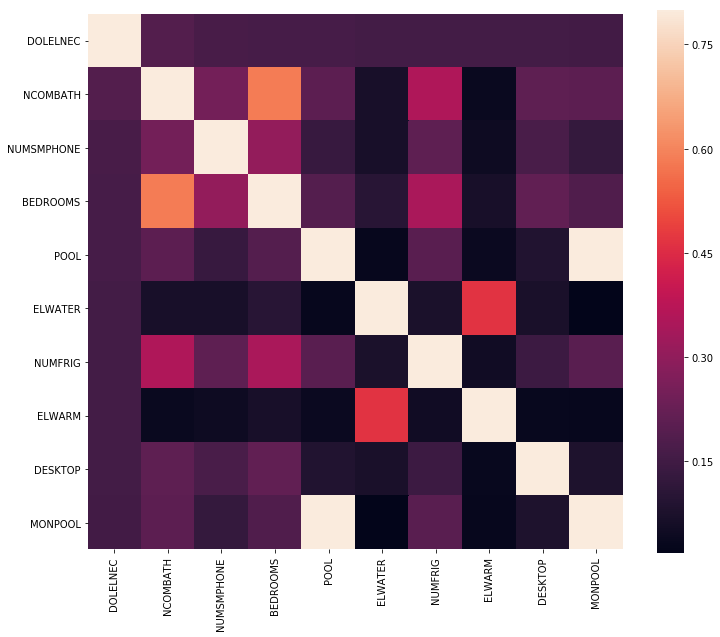

In [11]:
for col in COST_COLS:
    heatMap(pd.Index([col]), preproc.num_inds, X, k=10)

# 3.2 Conclusion

The darker area of the heat map shows that mere linear dependence is not enough. We will thus consider the next order square terms of the independent variables. Also, we have included many columns which should really be categorical variables. To these columns, we will make 1-hot-encoding.

The next step is as follows: 
1. separate categorical columns from true numerical ones. And encode them by 1-hot
2. Write a class to compute quadratic products of independent variables and add them to the set of independent variables
3. Compute the Pearson's correlation again and pick the top k=100 most correlated

# 4. Encode/1hot-encode categories

# 5 Nonlinearity
# 5.1 MakeQuad class makes quadratic terms

In [52]:
class MakeQuad(object):
    def __init__(self):
        self.size = None
    
    # assumes that X = data[preproc.var_cols]
    def fit(self, X):
        self.size = X.values.shape
    
    # assumes that nums = data[preproc.var_cols]
    def transform(self, nums):
        X = nums.copy().values
        a = X.reshape((self.size[0], self.size[1], 1))
        b = X.reshape((self.size[0], 1, self.size[1]))
        
        c = (a*b).reshape(self.size[0], self.size[1] ** 2)
        
        return pd.DataFrame(np.unique(c, axis=1), )
    
    # fit_transform: pd.DataFrame --> pd.DataFrame
    def fit_transform(self, nums):
        self.fit(nums)
        return self.transform(nums)


# 5.2 Data Processor Class to include quadratic nonlinearity

In [87]:
class Processor(object):
    def __init__(self, numSigFeat=10, quad=False, cost_cols=COST_COLS, stoc=True, stoc_max=300, debug=False):
        self.numSigFeat = numSigFeat
        self.corr = {}
        self.quader = MakeQuad()
        self.stoc = stoc
        self.stoc_max = stoc_max
        
        self.cor_inds = {} # correlated indices
        self.idp_inds = {} # independent indices
        self.cat_inds = {} # categorical indices
        self.dep_inds = cost_cols
        
        self.quad = quad
        self.debug = debug
    
    # assumes that data has dependent variables
    # num_inds = all numerical indices for dependent var
    # cat_inds = categorical indices
    def fit(self, data, num_inds, cat_inds, debug=False):
        X = data.copy()
        if debug:
            print(X.shape)
            
            
        self.cat_inds = cat_inds
        
        if self.quad:
            nums = X[num_inds]
            print(nums.columns)
            
            if debug:
                print(nums.shape)
                print(self.quader.fit_transform(nums).shape)
            nums = pd.concat([nums, self.quader.fit_transform(nums), X[self.dep_inds]], axis=1)
            num_inds = nums.columns
        else:
            nums = X[num_inds.append(self.dep_inds)]
        
        if debug:
            print(nums.shape)
        
        if self.stoc:
            temp = num_inds.difference(self.dep_inds)
            nums = pd.concat([nums[temp].sample(n=min(self.stoc_max, nums[temp].shape[1]), axis=1), 
                              nums[self.dep_inds]])
            num_inds = nums.columns
        
        if debug:
            print(num_inds)
            print(nums)
        
        corrmat = np.abs(nums.corr())
        
        if debug:
            print(corrmat.columns)
            print(corrmat)
        
        
        for dep_var in self.dep_inds: 
            if debug:
                print(dep_var)
            
            print(self.numSigFeat + self.dep_inds.size)
            cor_inds = corrmat.nlargest(29, columns=dep_var)[dep_var].index
            print(cor_inds)
            cor_inds = cor_inds.difference(self.dep_inds.difference(pd.Index([dep_var])))
            print(cor_inds)
            cor_inds = cor_inds[0: self.numSigFeat]
            print(cor_inds)
            
            idp_inds = num_inds.difference(cor_inds)
            
            self.cor_inds[dep_var] = cor_inds
            self.idp_inds[dep_var] = idp_inds
            self.corr[dep_var] = nums[cor_inds].corr()
    
    # returned data does not contain Id and SalePrice
    def transform(self, X, dep_var):
        return X[self.cor_inds[dep_var]], X[self.idp_inds[dep_var]], X[self.cat_inds]
    
    def fit_transform(self, data, num_inds, cat_inds, dep_var):
        self.fit(data, num_inds, cat_inds)
        return self.transform(data, dep_var)
    
    def show_cov(self, dep_var):        
        corr = self.corr[dep_var]
        f, ax = plt.subplots(figsize=(12,10))
        sns.heatmap(np.abs(corr), vmax = 1, square=True);


In [17]:
_data, _ = load_data(ratio=1)
preproc = Preprocessor()
data = preproc.fit_transform(_data.iloc[0:100,:])

In [88]:
num_inds = preproc.num_inds
'DOLLAREL' in num_inds

False

In [90]:
#prec = Processor(quad=True, stoc=True, stoc_max=10)
#prec.fit(data, num_inds, preproc.cat_inds ,debug=True) # 